In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
# % matplotlib inline

In [2]:
def mesh_grid(x_start, x_end, y_start, y_end, N, grid_properties=False, plotting=False, width=10.0):
    '''
    Generate 2D mesh grid.
    - used by other flow functions.
    
    Parameters:
    -------------------
    x_start, x_end : float, boundaries in the x-direction
    y_start, y_end : float, boundaries in the y-direction
    N : int, number of points in each direction
    grid_properties : bool, if True retruns mesh properties, 
                    x_start,x_end,y_start,y_end,X,Y
    plotting : bool, plot the meshgrid, default is False
    width : float, width of the plot, default is 10.0
    
    Returns:
    --------------
    gridpoints : if True
    mesh_plot : if True 
    None
    '''
    
    x = np.linspace(x_start, x_end, N)    # creates a 1D-array with the x-coordinates
    y = np.linspace(y_start, y_end, N)    # creates a 1D-array with the y-coordinates
    
    X, Y = np.meshgrid(x, y)              # generates a mesh grid
    
    if plotting:
        height = (y_end - y_start) / (x_end - x_start) * width
        plt.figure(figsize=(width, height))
        plt.xlabel('x', fontsize=16)
        plt.ylabel('y', fontsize=16)
        plt.xlim(x_start, x_end)
        plt.ylim(y_start, y_end)
        plt.scatter(X, Y, s=5, color='#CD2305', marker='o')
    
    if grid_properties:
        return (x_start, x_end, y_start, y_end, X, Y, N)
    return None

In [3]:
mesh_properties = mesh_grid(-1.0,2.0,-0.5,0.5,50, grid_properties=True)

In [4]:
# loading NACA0012 data from files
x_airfoil = np.loadtxt('resources/NACA0012_x.txt')  # X-corrdinates of the airfoil
y_airfoil = np.loadtxt('resources/NACA0012_y.txt')  # Y-corrdinates of the airfoil
sigma_airfoil = np.loadtxt('resources/NACA0012_sigma.txt')  # strength of the sources located at the surfaces

In [5]:
def NACA4digit(airfoil_number, points=1000, get_data=False, plotting=True, closed_trailing_edge=True, save_to_file=False):
    """Compute and plot coordinates of a NACA 4-digit airfoil.
    
    Arguments:
        number: Name of the requested 4-digt NACA airfoil entered as a string,
                i.e. '2412'
    
    Optional arguments:
        points: Number of desired airfoil coordinates
                (half(N) for upper and half(N) for lower surface)
        closed_trailing_edge: The trailing edge has a small but finite
                            thickness when using equations in [1] unaltered.
        save_to_file: Saves the coordinates in a CSV file.
        get_data: returns x and y coordinates
        plotting: plot the airfoil geometry
    
    Returns:
        A matrix with two columns pertaining to the x and y-coordinates,
        respectively. The sequence of coordinates is clockwise, starting at the
        trailing edge.
    
    Raises:
        ValueError: Airfoil number does not have four digits or N is negative
        
    References:
        https://en.wikipedia.org/wiki/NACA_airfoil
    
    """

    ## Check whether input parameters are valid or not
    if not (0 < int(airfoil_number) < 10000 and points > 0):
        raise ValueError("Invalid input.")

    c = 1       # by default chord(c) is set to 1; so x = c, x/c = 1

    ## 4-digit airfoil properties
    M = int(airfoil_number[0]) * (c/100)    # max camber
    P = int(airfoil_number[1]) * (c/10)     # max camber location from leading edge
    T = int(airfoil_number[2:4]) * (c/100)  # max thickness

    ## coordinates points
    N = points//2

    ## spacing of coordinates along the x-axis
    x = np.linspace(0, c, N)

    ## The trailing edge has a small but finite thickness by default. The gap
    # can be closed by utilizing a slightly different equation.
    if closed_trailing_edge:
        a4 = -0.1036   # Closed trailing edge
    else:
        a4 = -0.1015   # Open trailing edge

    ## constants
    a0 = 0.2969
    a1 = -0.1260
    a2 = -0.3516
    a3 = 0.2843

    ## Computing the y-coordinates of the camber line.
    # Camber & Gradient
    fwd_x = x[x < P]
    aft_x = x[x >= P]
    # camber calcultation
    if 0 < P < c:
        fwd_camber_yc = M / P**2 * (2 * P * fwd_x - np.power(fwd_x, 2))
        fwd_camber_dyc_dx = 2*M / P**2 * (P - fwd_x)
        aft_camber_yc = M / (1 - P)**2 * ((1 - 2 * P) + 2 * P * aft_x - np.power(aft_x, 2))
        aft_camber_dyc_dx = 2*M / (1-P)**2 * (P - aft_x)
        camber_yc = np.append(fwd_camber_yc, aft_camber_yc)   # complete mean camber line
        dyc_dx_camber = np.append(fwd_camber_dyc_dx, aft_camber_dyc_dx)
    else:
        camber_yc = np.zeros(np.size(x))   # cases where max_camber is located on leading or triling edge
        dyc_dx_camber = np.zeros(np.size(x))
    #gradient calculation
    theta = np.arctan(dyc_dx_camber)
    
    ## Thickness Distribution
    yt = 5*T*((a0*np.sqrt(x)) + (a1*x) + (a2*(x**2)) + (a3*(x**3)) + (a4*(x**4)))

    ## Upper surface points
    xu = x - (yt * np.sin(theta))
    yu = camber_yc + (yt* np.cos(theta))

    ## Lower surface points
    xl = x + (yt * np.sin(theta))
    yl = camber_yc - (yt * np.cos(theta))
    
    ## coordinates
    x_cord = np.append(xu, xl)
    y_cord = np.append(yu, yl)
    coordinates = np.column_stack((x_cord, y_cord))
    
    ## Saving data to CSV file
    if save_to_file:
        np.savetxt(f"NACA{airfoil_number}_plotting_data.csv", coordinates, delimiter=',')

    if plotting:
        ## Plot the airfoil
        plt.plot(x_cord, y_cord)
        plt.grid()
        plt.axis('equal')
        plt.show()
    
    if get_data:
        return x_cord, y_cord
    return None

In [6]:
def sourceFlow(x_source, y_source, source_strength, mesh_properties, width=10, data_output=False, plotting=True):
    '''
    Source Flow function.
    - A source is a point from which we imagine that fluid is flowing out, 
      uniformly. Thus, all the streamlines radiate from a single point as 
      straight lines and the radial velocity decreases with the distance 
      from the source point.
      
      - uses meshgrid Function to generate 2D grid
      
    Parameters:
    ----------------
    x_source : float, x-coordinate of source,
                must in inside the boundaries of meshgrid
    y_source : float, y-coordiante of source,
                must in inside the boundaries of meshgrid
    source_strength : positive float, strength of the source
    mesh_properties: Tuple, grid properties
    width : float, width of the plot, default is 10.0
    data_output : bool, if True, retruns the x and y velocites 
                        of source flow on meshgrid
    plotting : bool, plot the sourceflow velocity  field, default is True
    
    Returns:
    --------------
    data_output : if True
    velocityField_plot : if True 
    None
    '''
    
    # gettng values from mesh_properties
    x_start, x_end, y_start, y_end, X, Y, N = mesh_properties
    
    # compute the velocity field of source flow on the mesh grid
    u_source = (source_strength / (2 * math.pi) *
                (X - x_source) / ((X - x_source)**2 + (Y - y_source)**2))
    v_source = (source_strength / (2 * math.pi) *
                (Y - y_source) / ((X - x_source)**2 + (Y - y_source)**2))
    
    # compute the stream function of the source
    psi_source = source_strength / (2 * np.pi) * np.arctan2((Y - y_source), (X - x_source))

    if plotting:
        # plot the streamlines
        height = (y_end - y_start) / (x_end - x_start) * width
        plt.figure(figsize=(width, height))
        plt.xlabel('x', fontsize=16)
        plt.ylabel('y', fontsize=16)
        plt.xlim(x_start, x_end)
        plt.ylim(y_start, y_end)
        plt.streamplot(X, Y, u_source, v_source,
                          density=2, linewidth=1, arrowsize=2, arrowstyle='->')
        plt.scatter(x_source, y_source,
                       color='#CD2305', s=80, marker='o')
    
    if data_output:
        return u_source, v_source, psi_source
    return None

In [7]:
def sum_source_velocity(x_airfoil, y_airfoil, sigma_airfoil, mesh_properties):
    '''
    Calculate the sum of all Source sheets on the Airfoil surface
    
    Paramters:
    ------------
    x_airfoil : np.array, x-coordinates of the airfoil
    y_airfoil : np.array, y-coordinates of the airfoil
    sigma_airfoil : np.array, SourceStrength at each coordiantes of airfoil
    mesh_properties : tuple, grid properties
    
    Returns:
    ---------
    u_source : np.array, sum of all sources velocity at every location on grid
                in x-direction
    y_source : np.array, sum of all sources velocity at every location on grid
                in y-direction
    '''
    
    # gettng values from mesh_properties
    X, Y = mesh_properties[-2], mesh_properties[-3]
    
    u_source = np.zeros_like(X)
    v_source = np.zeros_like(Y)
    
    for (x, y, strength) in zip(x_airfoil, y_airfoil, sigma_airfoil):
        u_add, v_add, _ = sourceFlow(x, y, strength, mesh_properties, data_output=True, plotting=False)
        u_source += u_add
        v_source += v_add
    
    return u_source, v_source

In [8]:
def Freestream(u_inf, mesh_properties):
    '''
    Calculate freestream(Uniform Flow) velocity and streamline field
    
    - uses mesh_grid Function
    
    Parameters:
    ------------
    u_inf : float, free-stream speeed
    mesh_properties: Tuple, grid properties
    
    Returns:
    ---------
    u_freestream ,v_freestream : free-stream velocity field
    psi_freestream : stream-function 
    '''
    
    N = mesh_properties[-1]  # number of grid points
    Y = mesh_properties[-2]  # messgrid points array in y-direction
    
    # compute the freestream velocity field
    u_freestream = u_inf * np.ones((N,N), dtype=float)
    v_freestream = np.zeros((N,N), dtype=float)
    
    # compute the stream-function
    psi_freestream = u_inf * Y
    
    return u_freestream, v_freestream, psi_freestream

In [9]:
def NACA1200FlowAnalysis(x_airfoil, y_airfoil, sigma_airfoil, u_inf, mesh_properties, width=10, get_data=False, plotting=True):
    '''
    Non-lifting, No-Drag Incomressible Flow over Airfoil using
    source distribution method
    
    Paramters:
    ------------
    x_airfoil : np.array, x-coordinates of the airfoil
    y_airfoil : np.array, y-coordinates of the airfoil
    sigma_airfoil : np.array, SourceStrength at each coordiantes of airfoil
    u_inf : positive float, freestream speed
    mesh_properties : tuple, grid properties
    width : float, width of the plot, default is 10.0
    get_data : bool, if True retruns u, v
    plotting : bool, plot the meshgrid, default is True
    
    Returns:
    ---------
    Velocity field over NACA0012 Airfoil 
    '''
    
    # gettng values from mesh_properties
    x_start, x_end, y_start, y_end, X, Y, N = mesh_properties
    
    # getting the velocity values of SourceSet and freestream flow
    u_sourceSet, v_sourceSet = sum_source_velocity(x_airfoil, y_airfoil, sigma_airfoil, mesh_properties)
    u_freestream, v_freestream, _ = Freestream(u_inf, mesh_properties)
    
    u = u_sourceSet + u_freestream
    v = v_sourceSet + v_freestream
    
    if plotting:
        # plot the streamlines
        height = (y_end - y_start) / (x_end - x_start) * width
        plt.figure(figsize=(width, height))
        plt.xlabel('x', fontsize=16)
        plt.ylabel('y', fontsize=16)
        plt.xlim(x_start, x_end)
        plt.ylim(y_start, y_end)
        plt.streamplot(X, Y, u, v, 
                       density=2, linewidth=1, arrowsize=2, arrowstyle='->')
        plt.scatter(x_airfoil, y_airfoil, 
                color='#CD2305', s=20, marker='o')
        
    if get_data:
        return u,v
    return None

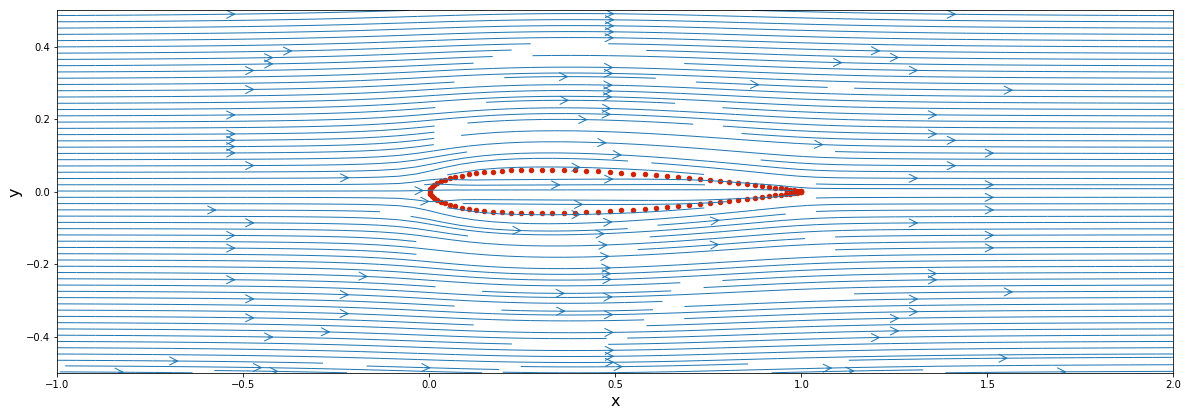

In [10]:
NACA1200FlowAnalysis(x_airfoil, y_airfoil, sigma_airfoil, 1.0, mesh_properties, width=20)

In [11]:
flow_properties = NACA1200FlowAnalysis(x_airfoil, y_airfoil, sigma_airfoil, 1.0, mesh_properties, width=20, get_data=True, plotting=False)

# Pressure Coefficient Field
def pressure_field(x_airfoil, y_airfoil, sigma_airfoil, flow_properties, u_inf, mesh_properties, width=10):
    '''
    Pressure Field Visulization for Freestream flow + Doublet
    
    Parameters:
    ------------
    flow_properties: tuple, flow properties of NACA1200FlowAnalysis
    mesh_properties: Tuple, grid properties
    width: positive float, width of the plot, default=10.0
    get_data : bool, if True retruns u, v
    plotting : bool, plot the meshgrid, default is True
    
    Returns:
    --------
    plot: Pressure Field over NACA0012 airfoil
    '''
    
#     # extracting values from flow proprties
#     u,v,psi = flow_properties[0],flow_properties[1],flow_properties[2]
#     u_inf = flow_properties[-1]
#     x_doublet,y_doublet = flow_properties[3], flow_properties[4]
#     x_stagn1, y_stagn1 = flow_properties[5], flow_properties[7]
#     x_stagn2, y_stagn2 = flow_properties[6], flow_properties[8]
    u = flow_properties[0]
    v = flow_properties[1]
    
    # compute the pressure coefficient field
    cp = 1.0 - (u**2 + v**2)/(u_inf**2)
    
    # Max pressure
    max_pressure = np.unravel_index(np.argmax(cp), cp.shape)
    
    # location of the max pressure in (x,y) coordinates
    def double_index_pair(X, Y, xy):
        '''
        Returns A Tuple of coordiantes of the point on MeshGrid
        - used for plotting
        '''
        x,y = xy
        return (X[x][y], Y[x][y])
    
    # get mesh_properties
    x_start, x_end, y_start, y_end, X, Y, N = mesh_properties
    
    # getting the airfoil coordinates from Airfoil Plotter
    x_cord_airfoil, y_cord_airfoil = NACA4digit('0012',points=1000, get_data=True, plotting=False)
    
    # plot the pressure coefficient field
    height = (y_end - y_start) / (x_end - x_start) * width
    plt.figure(figsize=(1.1 * width, height))
    plt.xlabel('x', fontsize=16)
    plt.ylabel('y', fontsize=16)
    plt.xlim(x_start, x_end)
    plt.ylim(y_start, y_end)
    contf = plt.contourf(X, Y, cp,
                            levels=np.linspace(-0.6, 0.75, 140), extend='both')
    cbar = plt.colorbar(contf)
    cbar.set_label('$C_p$', fontsize=16)
    cbar.set_ticks([-0.5, -0.25, 0.0, 0.25, 0.5, 0.75])
    # plots airfoil from airfoil plotter
    plt.plot(x_cord_airfoil, y_cord_airfoil, color='r')
    # plots sources on the airfoil surface
    #plt.scatter(x_airfoil, y_airfoil,
    #               color='#CD2305', s=20, marker='o')
    # plots max pressure point
    max_pressure_coords = double_index_pair(X, Y, max_pressure)
    plt.scatter(*max_pressure_coords,
                   color='#0022FF', s=80, marker='o')

    return None

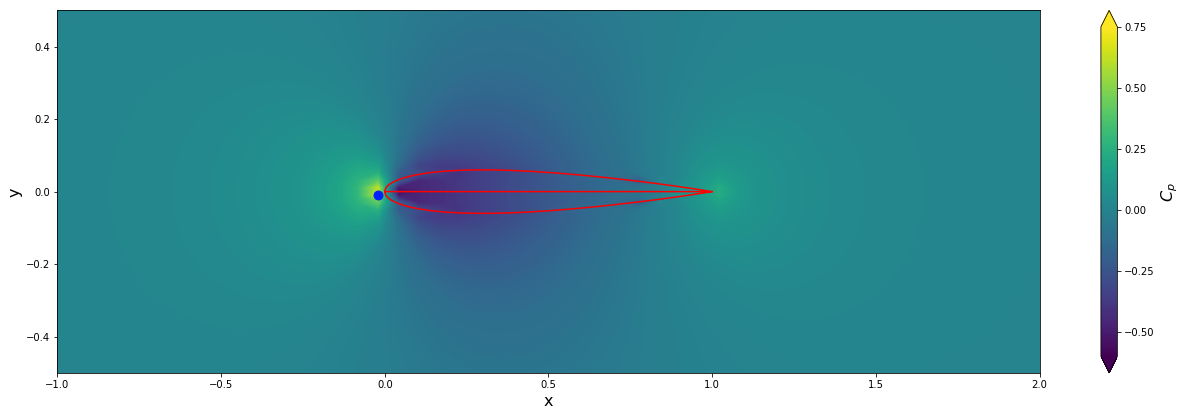

In [12]:
pressure_field(x_airfoil, y_airfoil, sigma_airfoil, flow_properties, 1.0, mesh_properties, width=20)